# Experimenting on NewsAPI

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

NEWS_API_KEY = os.getenv("NEWS_API_KEY")

In [2]:
import requests

url = ('https://newsapi.org/v2/everything?'
       'q=Artificial Intelligence&'
       'language=en&'
       f'apiKey={NEWS_API_KEY}')

response = requests.get(url)
response_json = response.json()

In [3]:
print(response_json)

{'status': 'ok', 'totalResults': 13753, 'articles': [{'source': {'id': None, 'name': 'Gizmodo.com'}, 'author': 'Jesse Coburn, ProPublica', 'title': 'Government by AI? Trump Admin Plans to Write Regulations Using Artificial Intelligence', 'description': 'Cutting out the middle man?', 'url': 'https://gizmodo.com/government-by-ai-trump-admin-plans-to-write-regulations-using-artificial-intelligence-2000713978', 'urlToImage': 'https://gizmodo.com/app/uploads/2026/01/Trump-AI-write-transportation-laws-1200x675.jpg', 'publishedAt': '2026-01-26T15:35:21Z', 'content': 'This story was originally published by ProPublica.\r\nThe Trump administration is planning to use artificial intelligence to write federal transportation regulations, according to U.S. Department of Tr… [+9921 chars]'}, {'source': {'id': 'wired', 'name': 'Wired'}, 'author': 'David Gilbert', 'title': 'AI-Powered Disinformation Swarms Are Coming for Democracy', 'description': 'Advances in artificial intelligence are creating a perf

In [4]:
response_json['articles'][0]

{'source': {'id': None, 'name': 'Gizmodo.com'},
 'author': 'Jesse Coburn, ProPublica',
 'title': 'Government by AI? Trump Admin Plans to Write Regulations Using Artificial Intelligence',
 'description': 'Cutting out the middle man?',
 'url': 'https://gizmodo.com/government-by-ai-trump-admin-plans-to-write-regulations-using-artificial-intelligence-2000713978',
 'urlToImage': 'https://gizmodo.com/app/uploads/2026/01/Trump-AI-write-transportation-laws-1200x675.jpg',
 'publishedAt': '2026-01-26T15:35:21Z',
 'content': 'This story was originally published by ProPublica.\r\nThe Trump administration is planning to use artificial intelligence to write federal transportation regulations, according to U.S. Department of Tr… [+9921 chars]'}

In [5]:
for idx, article in enumerate(response_json['articles'][:5]):
    print(f"Article {idx+1}")
    print(f"Title: {article['title']}")
    print(f"Author: {article['author']}")
    print(f"Source: {article['source']['name']}")
    print(f"Published At: {article['publishedAt']}")
    print(f"Read more: {article['url']}")
    print()

Article 1
Title: Government by AI? Trump Admin Plans to Write Regulations Using Artificial Intelligence
Author: Jesse Coburn, ProPublica
Source: Gizmodo.com
Published At: 2026-01-26T15:35:21Z
Read more: https://gizmodo.com/government-by-ai-trump-admin-plans-to-write-regulations-using-artificial-intelligence-2000713978

Article 2
Title: AI-Powered Disinformation Swarms Are Coming for Democracy
Author: David Gilbert
Source: Wired
Published At: 2026-01-22T19:00:00Z
Read more: https://www.wired.com/story/ai-powered-disinformation-swarms-are-coming-for-democracy/

Article 3
Title: New York is considering two bills to rein in the AI industry
Author: Terrence O’Brien
Source: The Verge
Published At: 2026-02-08T21:04:53Z
Read more: https://www.theverge.com/ai-artificial-intelligence/875501/new-york-is-considering-two-bills-to-rein-in-the-ai-industry

Article 4
Title: My Top Artificial Intelligence (AI) Stocks to Buy in 2026
Author: None
Source: Yahoo Entertainment
Published At: 2026-02-02T07:20

✅ Successfully fetched news using NewsAPI.

**Problem**:
- The free tier of NewsAPI truncates the article content. It only gives you the first ~200 characters and literally tells [+9921 chars] are missing.
- We cannot feed a 200-character snippet to an LLM and ask it to write a comprehensive, synthesized summary, nor can you build a useful RAG chatbot out of it.

**Solution**: Content Extraction Service
- pipeline must take the url provided by NewsAPI and scrape the actual webpage to get the full article body.

## Extracting the text from the url using
`trafilatura`

- Trafilatura is the benchmark leader, outperforming `Goose3`, `Readability`, and `Boilerpipe` with a 90.2% F1-score.
- It processes HTML 4.8x faster than `news-please`.
- It consistently retains critical metadata, such as authors, publish dates, and languages.
- It serves as the best general-purpose option by balancing accuracy, speed, and ease of use.

In [27]:
import trafilatura

In [11]:
downloaded = trafilatura.fetch_url(response_json['articles'][0]['url'])

In [12]:
trafilatura.extract(downloaded)

'This story was originally published by ProPublica.\nThe Trump administration is planning to use artificial intelligence to write federal transportation regulations, according to U.S. Department of Transportation records and interviews with six agency staffers.\nThe plan was presented to DOT staff last month at a demonstration of AI’s “potential to revolutionize the way we draft rulemakings,” agency attorney Daniel Cohen wrote to colleagues. The demonstration, Cohen wrote, would showcase “exciting new AI tools available to DOT rule writers to help us do our job better and faster.”\nDiscussion of the plan continued among agency leadership last week, according to meeting notes reviewed by ProPublica. Gregory Zerzan, the agency’s general counsel, said at that meeting that President Donald Trump is “very excited about this initiative.” Zerzan seemed to suggest that the DOT was at the vanguard of a broader federal effort, calling the department the “point of the spear” and “the first agency

In [25]:
def get_full_article(url: str):
    """
    Downloads and extracts the main text body from a given URL.
    """
    # Fetch the raw HTML content
    downloaded = trafilatura.fetch_url(url)

    # Check if download was blocked or failed
    if downloaded is None:
        return None
    
    # Extract the main text (bypassing ads, navbars, cookie banners)
    text = trafilatura.extract(downloaded)
    return text

In [18]:
full_text = get_full_article('https://htdocs.dev/posts/comparative-analysis-of-open-source-news-crawlers/')
print(f"Extracted full text length: {len(full_text) if full_text else 0} characters\n")
print(full_text if full_text else "Extraction failed. The site might block scrapers.")

Extracted full text length: 6295 characters

Summary of Key Findings
This report evaluates six open-source news crawlers—news-please, Fundus, news-crawler, news-crawl, Trafilatura, and newspaper4k—focusing on extraction accuracy, supported sites, and ease of use. Fundus and Trafilatura lead in precision and recall for text extraction, while newspaper4k excels in multilingual support and NLP integration. News-please and news-crawl are optimized for large-scale archival, with trade-offs in speed and configurability. Below, we dissect each tool’s strengths, weaknesses, and ideal use cases.
News-Please
Overview
news-please is a Python-based crawler designed for large-scale news extraction, integrating with CommonCrawl’s archive for historical data retrieval12.
Pros
- CommonCrawl Integration: Efficiently extracts articles from CommonCrawl’s vast archive, ideal for longitudinal studies12.
- Structured Metadata: Extracts titles, authors, publication dates, and multilingual content with 80+ la

Now that we know how to get the data, we need a place to store it.

Before moving forward with the automated fetcher script, we must build the Database Layer. This is where we define the structure of the data and how the FastAPI backend connects to PostgreSQL asynchronously.

# GoogleNews

In [2]:
from GoogleNews import GoogleNews

googlenews = GoogleNews()

In [3]:
print(googlenews.getVersion())

1.6.15


In [4]:
googlenews.enableException(True)

In [ ]:
googlenews = GoogleNews(lang='en', region='US', period='7d')

googlenews.search("Artficial Intelligence")

results = googlenews.result()

In [14]:
results

[{'title': '',
  'media': '',
  'date': '',
  'datetime': nan,
  'desc': '',
  'link': '/search?lr=lang_en&sca_esv=9fcb0994feb150f1&hl=en&gl=en&biw=1920&bih=976&tbs=lr:lang_1en,qdr:7d,sbd:1&tbm=nws&q=Artificial+Intelligence&spell=1',
  'img': ''},
 {'title': '',
  'media': '',
  'date': '',
  'datetime': nan,
  'desc': '',
  'link': '/search?lr=lang_en&sca_esv=9fcb0994feb150f1&hl=en&gl=en&biw=1920&bih=976&tbs=lr:lang_1en,qdr:7d,sbd:1&tbm=nws&q=Artficial+Intelligence&nfpr=1&sa=X&ved=2ahUKEwik6bzOt-uSAxXEQTABHe9aHLwQvgV6BAgLEAQ',
  'img': ''},
 {'title': 'Knowledge Networks Leads Global AI Dialogue at AI Impact Summit India 2026 with Focus on Ethical Artificial Intelligence',
  'media': 'Weekly Voice',
  'date': '9 minutes ago',
  'datetime': datetime.datetime(2026, 2, 21, 14, 26, 18, 848499),
  'desc': 'At the AI Impact Summit India 2026, Sanjay Puri, Founder & Chairman, Knowledge Networks, was on the panel “Trust in AI: Navigating Ethics and Policy,” along...',
  'link': 'https://weekl

In [16]:
print(results[0]['title'] if results[0]['title'] else "None")

None


In [23]:
for news in results:
    if news['title']:
        print(f"Title: {news['title']} ({news['date']})")
        print(f"\tMedia: {news['media']}")
        print(f"\tDescription: {news['desc']}")
        print(f"\tRead more: {news["link"]}")

Title: Knowledge Networks Leads Global AI Dialogue at AI Impact Summit India 2026 with Focus on Ethical Artificial Intelligence (9 minutes ago)
	Media: Weekly Voice
	Description: At the AI Impact Summit India 2026, Sanjay Puri, Founder & Chairman, Knowledge Networks, was on the panel “Trust in AI: Navigating Ethics and Policy,” along...
	Read more: https://weeklyvoice.com/knowledge-networks-leads-global-ai-dialogue-at-ai-impact-summit-india-2026-with-focus-on-ethical-artificial-intelligence/&ved=2ahUKEwik6bzOt-uSAxXEQTABHe9aHLwQxfQBegQIBxAC&usg=AOvVaw1n1-4ernjEj_MS2U-WuD7n
Title: Man Letting AI Rent Human Bodies Says Elon Musk Is His Hero (1 hour ago)
	Media: Futurism
	Description: Alex Liteplo, co-founder of RentAHuman, said that Elon Musk is the "entrepreneur hero" giving him inspiration.
	Read more: https://futurism.com/artificial-intelligence/rentahuman-musk-ai&ved=2ahUKEwik6bzOt-uSAxXEQTABHe9aHLwQxfQBegQIAhAC&usg=AOvVaw2YiGZRkvf_MRor4FmM1oPy
Title: Nvidia vs. Alphabet: Which Is th

In [30]:
full_text = get_full_article(results[4]['link'])
print(f"Extracted full text length: {len(full_text) if full_text else 0} characters\n")
print(full_text if full_text else "Extraction failed. The site might block scrapers.")

ERROR:trafilatura.downloads:not a 200 response: 404 for URL https://www.theglobeandmail.com/investing/markets/stocks/INTC-Q/pressreleases/348379/nvidia-vs-alphabet-which-is-the-best-artificial-intelligence-ai-stock-to-buy-now/&ved=2ahUKEwik6bzOt-uSAxXEQTABHe9aHLwQxfQBegQIChAC&usg=AOvVaw3CuIdjHu6hjVgmyAdXb_j0


Extracted full text length: 0 characters

Extraction failed. The site might block scrapers.


# Agent Graph

✅ High-DPI Graph Pipeline successfully saved to: /Users/neehanth/Documents/Data Scientist/ai_news_project/ai_news/assets/langgraph_workflow.png


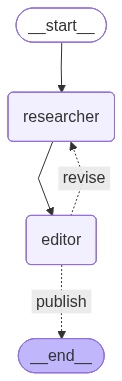

In [4]:
import os
import sys

# Add the project root (one level up) to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from IPython.display import display, Image
from src.agents.graph import app

output_dir = os.path.join(project_root, 'assets')

# Define the output path for the image
output_path = os.path.join(output_dir, 'langgraph_workflow.png')

# Generate the Mermaid PNG from the compiled Graph
png_bytes = app.get_graph().draw_mermaid_png()

# Save the image to the assets folder
with open(output_path, "wb") as f:
    f.write(png_bytes)

print(f"✅ High-DPI Graph Pipeline successfully saved to: {output_path}")

# Display it inline in the Jupyter Notebook
display(Image(png_bytes))